# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstyle data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP.

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm

%matplotlib inline

from IPython.display import Image
from IPython.display import clear_output
plt.rcParams['font.size'] = 20

### Read in data, downloading it first if necessary

In [2]:
def get_puidata():
    puidata = os.getenv("PUIDATA")
    if puidata is None:
        sys.stderr.write("PUIDATA environment variable must be defined.")
        sys.exit(1)
    else:
        return puidata

In [3]:
puidata = get_puidata()

In [4]:
def download_file(url, directory=puidata):
    if not os.path.isdir(directory):
        sys.stderr.write("You must either specify the directory or set puidata.")
        sys.exit(1)
    filename = url.split("/")[-1]
    os.system("wget -O " + directory + "/" + filename + " " +
              url)
    full_path = directory + "/" + filename
    if os.path.isfile(full_path):
        return full_path
    else:
        sys.stderr.write("Unable to download file.")
        sys.exit(1)

In [5]:
mta_filename = download_file("https://github.com/fedhere/PUI2018_fb55/raw/master/HW11_fb55/MTA_Fare.npy")
mta = np.load(mta_filename)

In [6]:
print("MTA array shape:", mta.shape)
print("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


create a "ride types" list based on the metadata I was given

In [7]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


In [8]:
# The dataset begins on a Friday, so using "W-FRI" will make sure weeks begin on Fridays
dates = pd.date_range(start="2010/05/21", periods=194, freq="W-FRI")

### Remove -1 values and replace them with NaNs

In [9]:
# Convert to float ndarray so we can use NaN-aware functions
mtaf = mta.astype(float)

# Need to is np.isnan since equality (==) doesn't work with NaNs
print("nancount is %s" % np.size(np.where(np.isnan(mtaf))))  
mtaf[mtaf == -1] = np.nan
neg_ones = np.where(mtaf == -1.0)
if np.size(neg_ones) == 0:
    print("There are no more -1 values in the array")
print("nancount is %s" % np.size(np.where(np.isnan(mtaf))))

nancount is 0
There are no more -1 values in the array
nancount is 1948689


# 4. Fourier transform
from the numpy package you will nees only the 
np.fft.rfft() to take the fourier transform

and

np.fft.rfftfreq() to create a meaningful x axis 

Several stations show a prominent annual periodicity. Identify the 4 stations (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

In [10]:
mtaf.shape

(600, 23, 194)

In [11]:
# Find out where on the x-axis 52 weeks would fall
# It's between indices 3 and 4
print("%0.2f weeks" % (1.0 / np.fft.rfftfreq(194, 1.0)[3]))
print("%0.2f weeks" % (1.0 / np.fft.rfftfreq(194, 1.0)[4]))

64.67 weeks
48.50 weeks


In [12]:
# Perform fourier transform
# This makes each series 98 elements long
mta_fft = np.fft.rfft(mtaf[:,:,:], axis=2).real ** 2
print(mta_fft.shape)

(600, 23, 98)


In [13]:
# Find the series with the greatest values in the 3rd or 4th index

# First, create a 600 x 23 array containing the value at the 3rd or 4th index, whichever is greater
mta_fft_year_max = mta_fft[:,:,3:5].max(axis=2)

# We want to find four stations, and not four combinations of station / card type, so let's consolidate by station
# by taking the max at each station
mta_fft_year_max = mta_fft_year_max.max(axis=1)

# Then, get the four station indices with the maximum values 
four_greatest_indcs = np.argpartition(mta_fft_year_max, -4)[-4:]

print("The four stations with the greatest yearly periodicity are: %s" % four_greatest_indcs)

The four stations with the greatest yearly periodicity are: [201 199 198 599]


In [14]:
np.fft.rfftfreq(194, 1.0).shape

(98,)

[Text(0,0,'-10.0'),
 Text(0,0,'inf'),
 Text(0,0,'10.0'),
 Text(0,0,'5.0'),
 Text(0,0,'3.33333333333'),
 Text(0,0,'2.5'),
 Text(0,0,'2.0'),
 Text(0,0,'1.66666666667')]

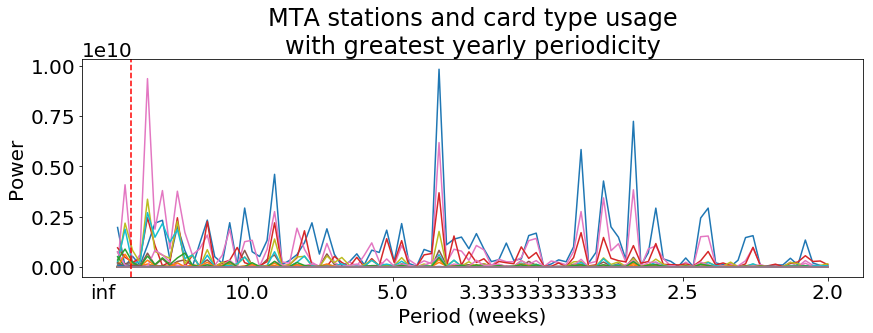

In [15]:
fig = plt.figure(figsize=(14,4))
ax = fig.subplots()
ax.set_title("MTA stations and card type usage\nwith greatest yearly periodicity")
ax.set_xlabel("Period (weeks)")
ax.set_ylabel("Power")

for station_idx in four_greatest_indcs:
        plt.plot(np.fft.rfftfreq(194, 1.0)[2:], 
                 (np.fft.rfft(mtaf[station_idx,:,:]).real ** 2)[:,2:].transpose(),
                 label=("station %s" % station_idx)
                )
plt.axvline(x=1/52, color="red", linestyle="dashed", label="52 weeks")
        
ax.set_xticklabels(["%s" % (1 / x) for x in ax.get_xticks()])

#### Figure 1: power spectrum for the four MTA stations that have the greatest yearly periodicity present in the time series data given. All card types are shown as separate lines. A red dotted line is shown at the point where the period is 52 weeks. This falls in between the periods where we explicitly have data, which are the periods of 64.67 weeks and 48.50 weeks. To estimate the stations with the greatest periodicity for the 52-week period, we used the maximum of each of those values.

### Conclusion
Since we can't identify stations by name or location, and only by index, it may be difficult to draw conclusions about what the cause of our 52-week periodicity may be. One possible theory is that it is related to the annual increases in travel around the holiday period, since these occur (generally) at the same time every year.